In [61]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
# Import specific functions instead of wildcard to avoid conflicts
import pyspark.sql.functions as F
from collections import defaultdict, Counter
from itertools import combinations
import copy
import time
import numpy as np
# Import builtins to ensure we use Python built-in functions
import builtins
import psutil
import os

In [62]:
# 🚀 CẤU HÌNH KẾT NỐI SPARK CLUSTER

# =============================================================================
# CHỌN LOẠI CLUSTER (chỉ uncomment 1 trong những cấu hình dưới đây)
# =============================================================================

# 1. LOCAL MODE - Chạy trên máy local (phù hợp để test)
# CLUSTER_CONFIG = {
#     "master": "local[*]",  # Sử dụng tất cả cores có sẵn
#     "app_name": "DUP-Apriori-Local",
#     "driver_memory": "2g",
#     "executor_memory": "3g",
#     "max_result_size": "2g"
# }

# 2. STANDALONE CLUSTER - Cấu hình tối ưu cho cluster hiện tại
CLUSTER_CONFIG = {
    "master": "spark://192.168.17.6:7077",  # Master URL của cluster
    "app_name": "DUP-Apriori-Optimized",
    "driver_memory": "1g",                   # Giảm driver memory để tiết kiệm cho executors
    "executor_memory": "3g",                 # 3GB/executor (để lại 1GB cho OS)
    "executor_cores": "2",                   # Sử dụng tất cả cores của mỗi worker
    "num_executors": "2",                    # 2 executors (1 trên mỗi worker)
    "max_result_size": "2g"                  # Giảm để phù hợp với driver memory
}

print(f"🎯 Cấu hình cluster được chọn: {CLUSTER_CONFIG['master']}")
print(f"📱 App name: {CLUSTER_CONFIG['app_name']}")
print(f"💾 Driver memory: {CLUSTER_CONFIG.get('driver_memory', 'default')}")
print(f"⚡ Executor memory: {CLUSTER_CONFIG.get('executor_memory', 'default')}")

🎯 Cấu hình cluster được chọn: spark://192.168.17.6:7077
📱 App name: DUP-Apriori-Optimized
💾 Driver memory: 1g
⚡ Executor memory: 3g


In [63]:
# 🚀 KHỞI TẠO SPARK SESSION VỚI CLUSTER CONFIG

try:
    # Dừng session cũ nếu có
    if 'spark' in locals():
        spark.stop()
        print("🔄 Đã dừng Spark session cũ")
except:
    pass

# Tạo SparkConf với cấu hình cluster
conf = SparkConf()
conf.setAppName(CLUSTER_CONFIG["app_name"])
conf.setMaster(CLUSTER_CONFIG["master"])

# Cấu hình memory và cores
if "driver_memory" in CLUSTER_CONFIG:
    conf.set("spark.driver.memory", CLUSTER_CONFIG["driver_memory"])
if "executor_memory" in CLUSTER_CONFIG:
    conf.set("spark.executor.memory", CLUSTER_CONFIG["executor_memory"])
if "executor_cores" in CLUSTER_CONFIG:
    conf.set("spark.executor.cores", CLUSTER_CONFIG["executor_cores"])
if "num_executors" in CLUSTER_CONFIG:
    conf.set("spark.executor.instances", CLUSTER_CONFIG["num_executors"])
if "max_result_size" in CLUSTER_CONFIG:
    conf.set("spark.driver.maxResultSize", CLUSTER_CONFIG["max_result_size"])

# Cấu hình tối ưu cho DUP-Apriori với cluster nhỏ
conf.set("spark.sql.adaptive.enabled", "true")
conf.set("spark.sql.adaptive.coalescePartitions.enabled", "true")
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
conf.set("spark.sql.shuffle.partitions", "8")        # Giảm từ 200 -> 8 cho cluster nhỏ
conf.set("spark.default.parallelism", "4")           # = tổng số cores

# Cấu hình compression để tiết kiệm bandwidth
conf.set("spark.io.compression.codec", "snappy")
conf.set("spark.rdd.compress", "true")

# Cấu hình memory cho cluster nhỏ
conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
conf.set("spark.executor.memory.fraction", "0.8")    # 80% memory cho cache
conf.set("spark.executor.memory.storageFraction", "0.3")  # 30% storage cho RDD cache

# Giới hạn cores để tránh oversubscription
conf.set("spark.cores.max", "4")                     # = tổng cores cluster
    
# Tạo SparkSession
try:
    spark = SparkSession.builder.config(conf=conf).getOrCreate()
    sc = spark.sparkContext
    
    # Thiết lập checkpoint directory
    checkpoint_dir = "/tmp/spark-checkpoints"
    sc.setCheckpointDir(checkpoint_dir)
    
    print("\n✅ KẾT NỐI SPARK CLUSTER THÀNH CÔNG!")
    print(f"🎯 Master: {sc.master}")
    print(f"📱 App Name: {sc.appName}")
    print(f"🔢 Default Parallelism: {sc.defaultParallelism}")
    print(f"📁 Checkpoint Dir: {checkpoint_dir}")
    
    # Hiển thị thông tin cluster
    print(f"\n🔍 THÔNG TIN CLUSTER:")
    print(f"Version: {sc.version}")
    print(f"Driver Memory: {spark.conf.get('spark.driver.memory')}")
    print(f"Executor Memory: {spark.conf.get('spark.executor.memory')}")
    print(f"Executor Cores: {spark.conf.get('spark.executor.cores')}")
    
    if CLUSTER_CONFIG["master"] != "local[*]":
        print(f"📊 Spark UI: {sc.uiWebUrl}")
    else:
        print(f"📊 Spark UI: http://localhost:4040")
        
except Exception as e:
    print(f"❌ LỖI KẾT NỐI CLUSTER: {e}")
    print("\n🔧 HƯỚNG DẪN KHẮC PHỤC:")
    print("1. Kiểm tra cluster đã chạy chưa")
    print("2. Xác nhận địa chỉ master đúng")
    print("3. Kiểm tra firewall/network connectivity")
    print("4. Thử chuyển về local mode để test")
    raise

🔄 Đã dừng Spark session cũ


25/06/02 16:21:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/02 16:21:50 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.



✅ KẾT NỐI SPARK CLUSTER THÀNH CÔNG!
🎯 Master: spark://192.168.17.6:7077
📱 App Name: DUP-Apriori-Optimized
🔢 Default Parallelism: 4
📁 Checkpoint Dir: /tmp/spark-checkpoints

🔍 THÔNG TIN CLUSTER:
Version: 3.5.5
Driver Memory: 1g
Executor Memory: 3g
Executor Cores: 2
📊 Spark UI: http://bigdata-master:4042


25/06/02 16:21:51 WARN SparkContext: Spark is not running in local mode, therefore the checkpoint directory must not be on the local filesystem. Directory '/tmp/spark-checkpoints' appears to be on the local filesystem.


In [64]:
# 🧪 KIỂM TRA KẾT NỐI VÀ HIỆU SUẤT CLUSTER

print("🔍 KIỂM TRA KẾT NỐI CLUSTER...")

try:
    # Test 1: Tạo RDD đơn giản
    test_rdd = sc.parallelize(range(100), 4)
    result = test_rdd.map(lambda x: x * 2).reduce(lambda a, b: a + b)
    print(f"✅ Test RDD: {result} (expected: 9900)")
    
    # Test 2: Kiểm tra số partitions
    print(f"📊 Số partitions test: {test_rdd.getNumPartitions()}")
    
    # Test 3: Kiểm tra executor info (chỉ với cluster mode)
    if CLUSTER_CONFIG["master"] != "local[*]":
        executor_infos = sc.statusTracker().getExecutorInfos()
        print(f"👥 Số executors đang hoạt động: {len(executor_infos)}")
        for i, executor in enumerate(executor_infos):
            if executor.executorId != "driver":
                print(f"   Executor {executor.executorId}: {executor.host}:{executor.port}")
    
    # Test 4: Benchmark đơn giản
    print("\n⚡ BENCHMARK HIỆU SUẤT:")
    import time
    
    # Test với dữ liệu lớn hơn
    start_time = time.time()
    large_rdd = sc.parallelize(range(1000000), sc.defaultParallelism)
    count = large_rdd.filter(lambda x: x % 2 == 0).count()
    benchmark_time = time.time() - start_time
    
    print(f"📈 Xử lý 1M records: {benchmark_time:.2f}s")
    print(f"🎯 Kết quả: {count:,} số chẵn")
    print(f"⚡ Tốc độ: {1000000/benchmark_time:,.0f} records/second")
    
    # Test memory usage
    memory = psutil.virtual_memory()
    print(f"💾 Memory usage: {memory.percent}% ({memory.used/(1024**3):.1f}GB/{memory.total/(1024**3):.1f}GB)")
    
    print("\n🎉 CLUSTER SẴN SÀNG CHO DUP-APRIORI!")
    
except Exception as e:
    print(f"❌ Lỗi kiểm tra cluster: {e}")
    print("⚠️  Cluster có thể chưa sẵn sàng hoặc cấu hình sai")

🔍 KIỂM TRA KẾT NỐI CLUSTER...


✅ Test RDD: 9900 (expected: 9900)
📊 Số partitions test: 4
❌ Lỗi kiểm tra cluster: 'StatusTracker' object has no attribute 'getExecutorInfos'
⚠️  Cluster có thể chưa sẵn sàng hoặc cấu hình sai


## 🎯 Cấu hình cluster được tối ưu

**Cluster hiện tại:**
- **2 Workers**: `192.168.17.6:43501` và `192.168.17.8:34177`
- **4 Total Cores**: 2 cores/worker  
- **8GB Total Memory**: 4GB/worker

**Cấu hình tối ưu:**
- Driver Memory: 1GB (để lại memory cho executors)
- Executor Memory: 3GB/executor 
- Shuffle Partitions: 8 (giảm từ 200)
- Parallelism: 4 (= tổng cores)

**Monitor cluster:**
- Master UI: http://192.168.17.6:8080
- Application UI: Xem trong output cell trên

In [65]:
# 📊 HIỂN THỊ CHI TIẾT CLUSTER CONFIGURATION

print("="*50)
print("🎯 CLUSTER CONFIGURATION SUMMARY")  
print("="*50)

print(f"🏗️  INFRASTRUCTURE:")
print(f"   Workers: 2 nodes")
print(f"   Cores: 4 total (2 per worker)")
print(f"   Memory: 8GB total (4GB per worker)")

print(f"\n⚙️  SPARK CONFIG:")
print(f"   Driver Memory: {CLUSTER_CONFIG['driver_memory']}")
print(f"   Executor Memory: {CLUSTER_CONFIG['executor_memory']}")
print(f"   Executors: {CLUSTER_CONFIG['num_executors']}")

print(f"\n🔧 OPTIMIZATIONS:")
print(f"   Shuffle Partitions: {spark.conf.get('spark.sql.shuffle.partitions')}")
print(f"   Parallelism: {spark.conf.get('spark.default.parallelism')}")
print(f"   Serializer: Kryo")

print(f"\n📊 MONITORING:")
print(f"   Master UI: http://192.168.17.6:8080")
if 'sc' in locals():
    print(f"   App UI: {sc.uiWebUrl}")

print("="*50)

🎯 CLUSTER CONFIGURATION SUMMARY
🏗️  INFRASTRUCTURE:
   Workers: 2 nodes
   Cores: 4 total (2 per worker)
   Memory: 8GB total (4GB per worker)

⚙️  SPARK CONFIG:
   Driver Memory: 1g
   Executor Memory: 3g
   Executors: 2

🔧 OPTIMIZATIONS:
   Shuffle Partitions: 8
   Parallelism: 4
   Serializer: Kryo

📊 MONITORING:
   Master UI: http://192.168.17.6:8080
   App UI: http://bigdata-master:4042


In [66]:
# 🧪 KIỂM TRA KẾT NỐI VÀ HIỆU SUẤT CLUSTER - PHIÊN BẢN SỬA LỖI

print("🔍 KIỂM TRA KẾT NỐI CLUSTER...")

try:
    # Test 1: Tạo RDD đơn giản
    test_rdd = sc.parallelize(range(100), 4)
    result = test_rdd.map(lambda x: x * 2).reduce(lambda a, b: a + b)
    print(f"✅ Test RDD: {result} (expected: 9900)")
    
    # Test 2: Kiểm tra số partitions
    print(f"📊 Số partitions test: {test_rdd.getNumPartitions()}")
    
    # Test 3: Kiểm tra executor info - VỚI ERROR HANDLING
    if CLUSTER_CONFIG["master"] != "local[*]":
        try:
            if hasattr(sc.statusTracker(), 'getExecutorInfos'):
                executor_infos = sc.statusTracker().getExecutorInfos()
                print(f"👥 Số executors đang hoạt động: {len(executor_infos)}")
                for i, executor in enumerate(executor_infos):
                    if executor.executorId != "driver":
                        print(f"   Executor {executor.executorId}: {executor.host}:{executor.port}")
            else:
                print("👥 Executor info: Không khả dụng trong phiên bản Spark này")
                print(f"   Master: {sc.master}")
                print(f"   Default Parallelism: {sc.defaultParallelism}")
                print(f"   UI URL: {sc.uiWebUrl}")
        except Exception as e:
            print(f"👥 Không thể lấy thông tin executors: {e}")
            print("   Cluster vẫn hoạt động bình thường (RDD tests passed)")
    
    # Test 4: Benchmark đơn giản
    print("\n⚡ BENCHMARK HIỆU SUẤT:")
    import time
    
    start_time = time.time()
    large_rdd = sc.parallelize(range(10000), sc.defaultParallelism)
    compute_result = large_rdd.map(lambda x: x ** 2).filter(lambda x: x % 2 == 0).count()
    benchmark_time = time.time() - start_time
    
    print(f"   Xử lý 10,000 records: {benchmark_time:.3f}s")
    print(f"   Kết quả: {compute_result} số chẵn")
    print(f"   Throughput: {10000/benchmark_time:,.0f} records/second")
    
    print("\n🎉 CLUSTER SẴN SÀNG CHO DUP-APRIORI!")
    
except Exception as e:
    print(f"❌ Lỗi kiểm tra cluster: {e}")
    print("⚠️  Cluster có thể chưa sẵn sàng hoặc cấu hình sai")

🔍 KIỂM TRA KẾT NỐI CLUSTER...


✅ Test RDD: 9900 (expected: 9900)
📊 Số partitions test: 4
👥 Executor info: Không khả dụng trong phiên bản Spark này
   Master: spark://192.168.17.6:7077
   Default Parallelism: 4
   UI URL: http://bigdata-master:4042

⚡ BENCHMARK HIỆU SUẤT:
   Xử lý 10,000 records: 0.676s
   Kết quả: 5000 số chẵn
   Throughput: 14,789 records/second

🎉 CLUSTER SẴN SÀNG CHO DUP-APRIORI!


In [67]:
# 🔧 CLUSTER MANAGEMENT UTILITIES

def restart_spark_session(new_config=None):
    """Khởi động lại Spark session với config mới"""
    global spark, sc, CLUSTER_CONFIG
    
    try:
        if 'spark' in globals():
            spark.stop()
            print("🔄 Đã dừng Spark session cũ")
    except:
        pass
    
    if new_config:
        CLUSTER_CONFIG.update(new_config)
        print(f"🔧 Cập nhật config: {new_config}")
    
    print("🚀 Đang khởi tạo Spark session mới...")
    # Code khởi tạo sẽ ở cell trước

def switch_to_local_mode():
    """Chuyển về local mode (hữu ích khi cluster gặp sự cố)"""
    local_config = {
        "master": "local[*]",
        "app_name": "DUP-Apriori-Local-Fallback"
    }
    restart_spark_session(local_config)

def optimize_for_dataset_size(file_path):
    """Tự động điều chỉnh config dựa trên kích thước dataset"""
    import os
    
    if not os.path.exists(file_path):
        print(f"❌ File không tồn tại: {file_path}")
        return
    
    file_size_mb = os.path.getsize(file_path) / (1024 * 1024)
    print(f"📁 Kích thước file: {file_size_mb:.1f}MB")
    
    if file_size_mb < 100:
        recommended_config = {
            "master": "local[2]",
            "driver_memory": "2g",
            "executor_memory": "2g"
        }
        print("💡 Khuyến nghị: Local mode với 2 cores")
    elif file_size_mb < 1000:
        recommended_config = {
            "driver_memory": "4g",
            "executor_memory": "8g",
            "executor_cores": "4"
        }
        print("💡 Khuyến nghị: Tăng memory lên 4g/8g")
    else:
        recommended_config = {
            "driver_memory": "8g",
            "executor_memory": "16g",
            "executor_cores": "5",
            "num_executors": "5"
        }
        print("💡 Khuyến nghị: Cấu hình cao cho dataset lớn")
    
    print("🔧 Recommended config:")
    for key, value in recommended_config.items():
        print(f"  {key}: {value}")
    
    return recommended_config

def monitor_application():
    """Monitor ứng dụng Spark đang chạy"""
    if 'sc' not in globals():
        print("❌ SparkContext chưa được khởi tạo")
        return
    
    status = sc.statusTracker()
    
    print("📊 APPLICATION STATUS:")
    print(f"  App ID: {sc.applicationId}")
    print(f"  App Name: {sc.appName}")
    
    # Job information
    active_jobs = status.getActiveJobIds()
    print(f"  Active Jobs: {len(active_jobs)}")
    
    # Stage information  
    active_stages = status.getActiveStageIds()
    print(f"  Active Stages: {len(active_stages)}")
    
    # Executor information
    try:
        executors = status.getExecutorInfos()
        active_executors = [e for e in executors if e.isActive]
        print(f"  Active Executors: {len(active_executors)}")
        
        total_cores = sum(e.maxTasks for e in active_executors)
        print(f"  Total Cores: {total_cores}")
    except:
        print("  Executor info: Not available")


def quick_info():
    """Thông tin nhanh về cluster"""
    if 'sc' in globals():
        print(f"Master: {sc.master} | Parallelism: {sc.defaultParallelism} | UI: {sc.uiWebUrl}")
    else:
        print("❌ Spark chưa khởi tạo")

print("🔧 Cluster management utilities đã sẵn sàng!")
print("📋 Các lệnh hữu ích:")
print("   - quick_info(): Thông tin nhanh")
print("   - quick_test(): Test hiệu suất nhanh")
print("   - cluster_info(): Thông tin chi tiết")
print("   - monitor_application(): Monitor ứng dụng")
print("   - switch_to_local_mode(): Chuyển về local mode")
print("   - optimize_for_dataset_size('file.txt'): Tối ưu config theo file")

🔧 Cluster management utilities đã sẵn sàng!
📋 Các lệnh hữu ích:
   - quick_info(): Thông tin nhanh
   - quick_test(): Test hiệu suất nhanh
   - cluster_info(): Thông tin chi tiết
   - monitor_application(): Monitor ứng dụng
   - switch_to_local_mode(): Chuyển về local mode
   - optimize_for_dataset_size('file.txt'): Tối ưu config theo file


## ✅ Tóm tắt các bước cần thực hiện

### 🚀 Để sử dụng DUP-Apriori với Spark Cluster:

**Bước 1:** Chỉnh sửa cấu hình `CLUSTER_CONFIG` ở cell trên theo cluster của bạn

**Bước 2:** Chạy cell "KHỞI TẠO SPARK SESSION" để kết nối

**Bước 3:** Chạy cell "KIỂM TRA KẾT NỐI" để xác nhận

**Bước 4:** Sử dụng các hàm DUP-Apriori như bình thường

### 📝 Ví dụ sẻ dụng nhanh:

```python
# Kiểm tra thông tin cluster
quick_info()

# Test hiệu suất
quick_test()

# Tối ưu cấu hình cho dataset
optimize_for_dataset_size('/home/datdao/DUP-Apriori/retail.txt')

# Chạy DUP-Apriori
transactions_rdd = load_large_dataset_optimized('/home/datdao/DUP-Apriori/retail.txt')
results = dup_apriori_spark(transactions_rdd, minsup=0.01)
```

### ⚠️ Điều quan trọng về Support-based Ordering:

1. **1-itemsets được sắp xếp** theo support tăng dần
2. **Index mapping**: Item với support thấp nhất có index = 1
3. **Min/Max values**: Là indices của items, không phải giá trị alphabet
4. **Frequent itemsets**: Được sắp xếp theo min_item để áp dụng AprioriGen*
5. **Transaction grouping**: Duplicate transactions được gộp lại với field 'dup'

### 🔗 Links hữu ích:

- **Spark UI**: http://localhost:4040 (local) hoặc URL hiển thị sau khi kết nối
- **Spark Master UI**: http://localhost:8080 (standalone cluster)
- **YARN ResourceManager**: http://localhost:8088 (YARN cluster)

### ⚠️ Lưu ý quan trọng:

1. **Đảm bảo cluster đang chạy** trước khi kết nối
2. **Kiểm tra network connectivity** giữa máy và cluster
3. **Điều chỉnh memory/cores** theo kích thước dữ liệu
4. **Sử dụng Spark UI** để monitor hiệu suất
5. **Nếu gặp sự cố**, chạy `switch_to_local_mode()` để fallback
6. **Test với dataset nhỏ** trước khi chạy dataset lớn

## Các hàm tiện ích cho dữ liệu lớn

In [68]:
# Các hàm tiện ích để tối ưu hiệu suất với dữ liệu lớn

def optimize_rdd_partitions(rdd, target_partition_size_mb=128):
    """Tối ưu số partitions dựa trên kích thước dữ liệu"""
    try:
        # Ước tính kích thước dữ liệu
        sample_size = min(1000, rdd.count())
        if sample_size == 0:
            return rdd
        
        sample_data = rdd.take(sample_size)
        estimated_size_mb = len(str(sample_data)) * rdd.count() / sample_size / (1024 * 1024)
        
        optimal_partitions = max(1, int(estimated_size_mb / target_partition_size_mb))
        
        print(f"📊 Ước tính kích thước dữ liệu: {estimated_size_mb:.1f}MB")
        print(f"🔧 Số partitions hiện tại: {rdd.getNumPartitions()}")
        print(f"✨ Số partitions tối ưu: {optimal_partitions}")
        
        if optimal_partitions != rdd.getNumPartitions():
            if optimal_partitions > rdd.getNumPartitions():
                return rdd.repartition(optimal_partitions)
            else:
                return rdd.coalesce(optimal_partitions)
        return rdd
    except Exception as e:
        print(f"⚠️ Lỗi khi tối ưu partitions: {e}")
        return rdd

def checkpoint_rdd_periodically(rdd, step, checkpoint_interval=3):
    """Checkpoint RDD định kỳ để tránh stack overflow"""
    if step % checkpoint_interval == 0:
        print(f"🔄 Checkpoint RDD tại bước {step}")
        rdd.checkpoint()
        rdd.count()  # Trigger checkpoint
    return rdd

def monitor_memory_usage():
    """Giám sát sử dụng memory"""
    memory = psutil.virtual_memory()
    print(f"💾 Memory usage: {memory.percent}% ({memory.used / (1024**3):.1f}GB / {memory.total / (1024**3):.1f}GB)")
    
    if memory.percent > 85:
        print("⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.")

def load_large_dataset_optimized(file_path, chunk_size=10000):
    """Load dataset lớn một cách tối ưu"""
    print(f"📂 Đang load dataset: {file_path}")
    
    try:
        # Đọc file và tạo RDD
        lines_rdd = sc.textFile(file_path)
        
        # Tối ưu partitions ngay từ đầu
        lines_rdd = optimize_rdd_partitions(lines_rdd)
        
        # Parse transactions
        transactions_rdd = lines_rdd.map(lambda line: line.strip().split())
        
        # Filter empty transactions
        transactions_rdd = transactions_rdd.filter(lambda trans: len(trans) > 0)
        
        # Cache để tái sử dụng
        transactions_rdd.cache()
        
        total_count = transactions_rdd.count()
        print(f"✅ Load thành công {total_count} transactions")
        
        return transactions_rdd
        
    except Exception as e:
        print(f"❌ Lỗi khi load dataset: {e}")
        return None

def create_memory_efficient_broadcast(data, max_size_mb=100):
    """Tạo broadcast variable an toàn cho memory"""
    try:
        # Ước tính kích thước
        estimated_size_mb = len(str(data)) / (1024 * 1024)
        
        if estimated_size_mb > max_size_mb:
            print(f"⚠️ Dữ liệu quá lớn để broadcast ({estimated_size_mb:.1f}MB > {max_size_mb}MB)")
            return None
        
        print(f"📡 Broadcasting {estimated_size_mb:.1f}MB dữ liệu")
        return sc.broadcast(data)
        
    except Exception as e:
        print(f"❌ Lỗi khi tạo broadcast: {e}")
        return None

print("🛠️ Các hàm tiện ích đã được load!")

🛠️ Các hàm tiện ích đã được load!


## 🎯 Hướng dẫn sử dụng Spark DUP-Apriori với Dataset

### 📋 Các hàm chính đã được thêm:

#### 1. **Load Dataset**
```python
# Load toàn bộ dataset
transactions_rdd = load_dataset_spark('retail.txt')

# Load với giới hạn
transactions_rdd = load_dataset_spark('retail.txt', max_transactions=5000)
```

#### 2. **Phân tích Dataset**
```python
# Phân tích thông tin dataset
analyze_dataset_spark(transactions_rdd)
```

#### 3. **Test với Sample Data**
```python
# Test nhanh với sample data
test_with_sample_data_spark()
```

#### 4. **Test với Retail Dataset**
```python
# Test với retail dataset
results = test_with_retail_dataset_spark(max_transactions=1000, minsup=0.01)

# Test với dataset lớn hơn
results = test_with_retail_dataset_spark(max_transactions=10000, minsup=0.005)
```

#### 5. **Quick Test**
```python
# Test nhanh
results = quick_test_spark('retail.txt', max_trans=2000, minsup=0.01)
```

#### 6. **So sánh hiệu suất**
```python
# Chạy benchmark với nhiều kích thước khác nhau
perf_results = performance_comparison_spark()
```

### ⚙️ Cấu hình được khuyến nghị:

| Dataset Size | max_transactions | minsup | Thời gian ước tính |
|--------------|------------------|--------|--------------------|
| Small test   | 1,000           | 0.01   | < 10 giây          |
| Medium test  | 5,000           | 0.005  | 1-2 phút           |
| Large test   | 20,000          | 0.001  | 10-20 phút         |
| Full dataset | None (88K)      | 0.0005 | 1-2 giờ            |

### 🚀 Workflow được khuyến nghị:

1. **Bắt đầu với sample data:**
   ```python
   test_with_sample_data_spark()
   ```

2. **Test với dataset nhỏ:**
   ```python
   quick_test_spark('retail.txt', max_trans=1000, minsup=0.01)
   ```

3. **Tăng dần kích thước:**
   ```python
   test_with_retail_dataset_spark(max_transactions=5000, minsup=0.005)
   ```

4. **Chạy benchmark:**
   ```python
   performance_comparison_spark()
   ```

5. **Chạy với toàn bộ dataset:**
   ```python
   test_with_retail_dataset_spark(max_transactions=None, minsup=0.001)
   ```

### ⚠️ Lưu ý quan trọng:

- **Memory**: Dataset lớn cần nhiều memory. Monitor memory usage
- **Parallelism**: Spark tự động phân phối công việc
- **Caching**: RDD được cache để tăng tốc
- **Monitoring**: Theo dõi Spark UI tại http://localhost:4040

### 🔧 Troubleshooting:

**Nếu gặp lỗi OutOfMemoryError:**
```python
# Giảm max_transactions hoặc tăng executor memory
spark.conf.set("spark.executor.memory", "4g")
```

**Nếu chạy chậm:**
```python
# Tăng số partitions
spark.conf.set("spark.sql.shuffle.partitions", "16")
```

**Nếu dataset quá lớn:**
```python
# Sử dụng distributed processing với minsup cao hơn
distributed_apriori_spark(transactions_rdd, minsup=0.01)
```

# DUP-Apriori SPARK

In [69]:
# Biến toàn cục để lưu trữ ánh xạ item -> index (index dựa trên support tăng dần)
item_to_index = {}

class ItemSet:
    """Cấu trúc dữ liệu cho itemset với thông tin bổ sung - tối ưu cho Spark"""
    def __init__(self, itemset, sup=0):
        self.itemset = frozenset(itemset) if not isinstance(itemset, frozenset) else itemset
        self.sup = sup
        # Sử dụng index dựa trên support order cho min/max
        if itemset and item_to_index:
            indices = [item_to_index[item] for item in itemset if item in item_to_index]
            self.min_item = builtins.min(indices) if indices else None
            self.max_item = builtins.max(indices) if indices else None
        else:
            self.min_item = None
            self.max_item = None
    
    def __str__(self):
        return f"ItemSet({sorted(list(self.itemset))}, sup={self.sup:.3f}, min={self.min_item}, max={self.max_item})"
    
    def __repr__(self):
        return self.__str__()
    
    def __eq__(self, other):
        return self.itemset == other.itemset
    
    def __hash__(self):
        return hash(self.itemset)
    
    def to_dict(self):
        """Chuyển đổi sang dictionary để serialize trong Spark"""
        return {
            'itemset': list(self.itemset),
            'sup': self.sup,
            'min_item': self.min_item,
            'max_item': self.max_item
        }
    
    @classmethod
    def from_dict(cls, d):
        """Tạo ItemSet từ dictionary"""
        itemset = cls(d['itemset'], d['sup'])
        itemset.min_item = d['min_item']
        itemset.max_item = d['max_item']
        return itemset

class Transaction:
    """Cấu trúc dữ liệu cho transaction với thông tin bổ sung - tối ưu cho Spark"""
    def __init__(self, itemset, dup=1):
        self.itemset = frozenset(itemset) if not isinstance(itemset, frozenset) else itemset
        self.length = len(self.itemset)
        # Sử dụng index dựa trên support order cho min/max
        if itemset and item_to_index:
            indices = [item_to_index[item] for item in itemset if item in item_to_index]
            self.min_item = builtins.min(indices) if indices else None
            self.max_item = builtins.max(indices) if indices else None
        else:
            self.min_item = None
            self.max_item = None
        self.dup = dup  # số lần xuất hiện của transaction này
    
    def __str__(self):
        return f"Transaction({sorted(list(self.itemset))}, len={self.length}, min={self.min_item}, max={self.max_item}, dup={self.dup})"
    
    def __repr__(self):
        return self.__str__()
    
    def __eq__(self, other):
        return self.itemset == other.itemset
    
    def __hash__(self):
        return hash(self.itemset)
    
    def to_dict(self):
        """Chuyển đổi sang dictionary để serialize trong Spark"""
        return {
            'itemset': list(self.itemset),
            'length': self.length,
            'min_item': self.min_item,
            'max_item': self.max_item,
            'dup': self.dup
        }
    
    @classmethod
    def from_dict(cls, d):
        """Tạo Transaction từ dictionary"""
        trans = cls(d['itemset'], d['dup'])
        trans.length = d['length']
        trans.min_item = d['min_item']
        trans.max_item = d['max_item']
        return trans

In [70]:
def get_frequent_1_itemsets_spark(transactions_rdd, minsup):
    """Tìm các 1-itemsets phổ biến - song song hóa, sắp xếp theo support tăng dần"""
    # Đếm tần suất của từng item
    n = transactions_rdd.count()
    
    item_counts = transactions_rdd \
        .flatMap(lambda transaction: transaction) \
        .map(lambda item: (item, 1)) \
        .reduceByKey(lambda a, b: a + b)
    
    # Lọc những item có support >= minsup và sắp xếp theo support tăng dần
    frequent_1_itemsets = item_counts \
        .filter(lambda x: x[1] / n >= minsup) \
        .map(lambda x: ItemSet([x[0]], x[1] / n).to_dict()) \
        .sortBy(lambda x: x['sup'])  # Sắp xếp theo support tăng dần
    
    return frequent_1_itemsets, n

def create_item_index_mapping_spark(frequent_1_itemsets_rdd):
    """Tạo ánh xạ item -> index dựa trên thứ tự support tăng dần - bắt đầu từ index 1"""
    global item_to_index
    
    # Lấy danh sách items đã được sắp xếp theo support tăng dần
    items_with_support = frequent_1_itemsets_rdd.collect()
    
    # Đảm bảo sắp xếp theo support tăng dần (đã được sort ở get_frequent_1_itemsets_spark)
    sorted_items = sorted(items_with_support, key=lambda x: x['sup'])
    
    # Tạo mapping bắt đầu từ index 1, theo thứ tự support tăng dần
    item_to_index = {item['itemset'][0]: idx + 1 for idx, item in enumerate(sorted_items)}
    
    # print(f"📋 Item-to-index mapping (theo support tăng dần):")
    for item, index in sorted(item_to_index.items(), key=lambda x: x[1]):
        sup = next(i['sup'] for i in sorted_items if i['itemset'][0] == item)
        # print(f"   Item {item} -> Index {index} (support: {sup:.4f})")
    
    return sc.broadcast(item_to_index)

def preprocess_transactions_spark(transactions_rdd, item_to_index_bc):
    """Tiền xử lý transactions: gộp các transaction trùng lặp và tính min/max"""
    
    def process_transaction(trans):
        """Xử lý một transaction và tính min/max dựa trên item_to_index"""
        itemset = frozenset(trans)
        
        # Tính min/max dựa trên index (support order)
        if itemset and item_to_index_bc.value:
            indices = [item_to_index_bc.value[item] for item in itemset if item in item_to_index_bc.value]
            min_item = builtins.min(indices) if indices else None
            max_item = builtins.max(indices) if indices else None
        else:
            min_item = None
            max_item = None
        
        return {
            'itemset': list(itemset),
            'length': len(itemset),
            'min_item': min_item,
            'max_item': max_item,
            'dup': 1
        }
    
    # Chuyển đổi và group by itemset
    processed_transactions = transactions_rdd \
        .map(process_transaction) \
        .map(lambda trans: (tuple(sorted(trans['itemset'])), trans)) \
        .reduceByKey(lambda a, b: {
            'itemset': a['itemset'],
            'length': a['length'],
            'min_item': a['min_item'],
            'max_item': a['max_item'],
            'dup': a['dup'] + b['dup']
        }) \
        .map(lambda x: x[1])
    
    return processed_transactions

In [71]:
def calculate_support_spark(candidates_rdd, transactions_rdd, n, item_to_index_bc):
    """Tính support cho các ứng viên - phiên bản an toàn tránh lỗi broadcast variable"""
    
    # Collect candidates và transactions về driver để xử lý an toàn
    try:
        candidates_list = candidates_rdd.collect()
        transactions_list = transactions_rdd.collect()
        
        # Get item_to_index mapping an toàn
        item_to_index = item_to_index_bc.value
        
        print(f"   🔄 Xử lý {len(candidates_list)} candidates với {len(transactions_list)} transactions trên driver")
        
        # Xử lý support calculation trên driver để tránh broadcast variable corruption
        results = []
        
        for candidate_dict in candidates_list:
            # Tính lại min/max cho candidate dựa trên item_to_index
            candidate_itemset = set(candidate_dict['itemset'])
            if candidate_itemset and item_to_index:
                indices = [item_to_index[item] for item in candidate_itemset if item in item_to_index]
                candidate_min = builtins.min(indices) if indices else None
                candidate_max = builtins.max(indices) if indices else None
            else:
                candidate_min = None
                candidate_max = None
            
            support = 0
            for trans_dict in transactions_list:
                # Kiểm tra điều kiện: t.min <= c.min AND c.max <= t.max
                if (trans_dict['min_item'] is not None and candidate_min is not None and 
                    trans_dict['max_item'] is not None and candidate_max is not None):
                    if trans_dict['min_item'] <= candidate_min and candidate_max <= trans_dict['max_item']:
                        # Kiểm tra c ⊆ t (candidate là subset của transaction)
                        trans_itemset = set(trans_dict['itemset'])
                        if candidate_itemset.issubset(trans_itemset):
                            support += trans_dict['dup']
            
            # Cập nhật support và min/max vào candidate
            result_dict = candidate_dict.copy()
            result_dict['sup'] = support / n
            result_dict['min_item'] = candidate_min
            result_dict['max_item'] = candidate_max
            results.append(result_dict)
        
        print(f"   ✅ Hoàn thành tính support cho {len(results)} candidates")
        
        # Tạo RDD từ kết quả
        return sc.parallelize(results)
        
    except Exception as e:
        print(f"   ⚠️ Lỗi trong calculate_support_spark: {e}")
        print(f"   🔄 Thử phương pháp fallback...")
        
        # Fallback: sử dụng phương pháp distributed an toàn hơn
        return calculate_support_spark_distributed(candidates_rdd, transactions_rdd, n, item_to_index_bc)

def calculate_support_spark_distributed(candidates_rdd, transactions_rdd, n, item_to_index_bc):
    """Phiên bản phân tán an toàn hơn cho datasets lớn"""
    
    # Để tránh broadcast variable corruption, ta sẽ join thay vì broadcast
    # Đầu tiên, tạo RDD chứa item_to_index mapping
    item_to_index = item_to_index_bc.value
    item_index_rdd = sc.parallelize(list(item_to_index.items()))
    
    # Prepare candidates với keys để join
    def prepare_candidate(candidate):
        candidate_itemset = candidate['itemset']
        # Tạo các cặp (item, candidate) để join với item_index
        return [(item, candidate) for item in candidate_itemset]
    
    candidate_items_rdd = candidates_rdd.flatMap(prepare_candidate)
    
    # Join candidates với item indices
    candidate_with_indices = candidate_items_rdd.join(item_index_rdd)
    
    # Group lại theo candidate để tính min/max
    def group_candidate_indices(item_candidate_index):
        item, (candidate, index) = item_candidate_index
        candidate_key = tuple(sorted(candidate['itemset']))
        return (candidate_key, (candidate, index))
    
    candidates_grouped = candidate_with_indices.map(group_candidate_indices).groupByKey()
    
    # Tính min/max cho mỗi candidate
    def compute_candidate_minmax(candidate_group):
        candidate_key, candidate_indices = candidate_group
        candidate_indices_list = list(candidate_indices)
        
        # Lấy candidate dict (tất cả đều giống nhau)
        candidate_dict = candidate_indices_list[0][0]
        
        # Tính min/max từ indices
        indices = [idx for _, idx in candidate_indices_list]
        candidate_min = builtins.min(indices) if indices else None
        candidate_max = builtins.max(indices) if indices else None
        
        # Cập nhật candidate
        result = candidate_dict.copy()
        result['min_item'] = candidate_min
        result['max_item'] = candidate_max
        result['candidate_key'] = candidate_key
        
        return result
    
    candidates_with_minmax = candidates_grouped.map(compute_candidate_minmax)
    
    # Broadcast transactions để tính support
    transactions_list = transactions_rdd.collect()
    transactions_bc = sc.broadcast(transactions_list)
    
    def compute_support_safe(candidate):
        """Tính support một cách an toàn"""
        candidate_itemset = set(candidate['itemset'])
        candidate_min = candidate['min_item']
        candidate_max = candidate['max_item']
        
        support = 0
        try:
            transactions = transactions_bc.value
            for trans_dict in transactions:
                # Kiểm tra điều kiện: t.min <= c.min AND c.max <= t.max
                if (trans_dict['min_item'] is not None and candidate_min is not None and 
                    trans_dict['max_item'] is not None and candidate_max is not None):
                    if trans_dict['min_item'] <= candidate_min and candidate_max <= trans_dict['max_item']:
                        # Kiểm tra c ⊆ t (candidate là subset của transaction)
                        trans_itemset = set(trans_dict['itemset'])
                        if candidate_itemset.issubset(trans_itemset):
                            support += trans_dict['dup']
        except Exception as e:
            print(f"Warning: Error accessing broadcast variable: {e}")
            # Fallback: return candidate with 0 support
            support = 0
        
        # Cập nhật support
        result = candidate.copy()
        result['sup'] = support / n
        return result
    
    result_rdd = candidates_with_minmax.map(compute_support_safe)
    
    # Clean up
    transactions_bc.unpersist()
    
    return result_rdd

def filter_frequent_itemsets_spark(itemsets_with_support_rdd, minsup):
    """Lọc các itemsets có support >= minsup - song song hóa"""
    return itemsets_with_support_rdd.filter(lambda x: x['sup'] >= minsup)

def prune_transactions_spark(transactions_rdd, k):
    """Rút gọn transactions: loại bỏ những transaction có ít hơn k items - song song hóa"""
    return transactions_rdd.filter(lambda trans: trans['length'] >= k)

def apriori_gen_star_spark(frequent_itemsets_rdd):
    """Sinh ứng viên k+1-itemsets từ k-itemsets theo đúng mã giả AprioriGen* - sắp xếp theo min_item"""
    frequent_itemsets = frequent_itemsets_rdd.collect()
    
    # Nếu chỉ có 1 hoặc ít hơn frequent itemsets, không thể tạo candidates
    if len(frequent_itemsets) <= 1:
        return sc.parallelize([])
    
    # Sắp xếp theo min_item như trong thuật toán gốc (min_item đã được tính theo support order)
    frequent_itemsets.sort(key=lambda x: x['min_item'])
    
    print(f"   📋 Frequent itemsets để sinh candidates (sắp xếp theo min_item):")
    for fi in frequent_itemsets[:5]:  # Hiển thị 5 đầu tiên
        print(f"      {sorted(fi['itemset'])} (min={fi['min_item']}, max={fi['max_item']})")
    if len(frequent_itemsets) > 5:
        print(f"      ... và {len(frequent_itemsets)-5} itemsets khác")
    
    candidates = []
    
    # Thực hiện theo đúng mã giả AprioriGen*
    i = 0
    while i < len(frequent_itemsets):
        j = i + 1
        
        # Vòng lặp inner theo mã giả
        while j < len(frequent_itemsets):
            X_i = frequent_itemsets[i]
            X_j = frequent_itemsets[j]
            
            # Dòng 6: Kiểm tra điều kiện X_i.min == X_j.min
            if X_i['min_item'] == X_j['min_item']:
                # Dòng 7: Tạo itemset mới từ hợp của X_i và X_j
                new_itemset = set(X_i['itemset']).union(set(X_j['itemset']))
                
                # Tính min/max cho candidate mới
                if new_itemset and item_to_index:
                    indices = [item_to_index[item] for item in new_itemset if item in item_to_index]
                    new_min = builtins.min(indices) if indices else None
                    new_max = builtins.max(indices) if indices else None
                else:
                    new_min = None
                    new_max = None
                
                new_candidate = {
                    'itemset': list(new_itemset),
                    'sup': 0,  # Sẽ được tính sau
                    'min_item': new_min,
                    'max_item': new_max
                }
                
                # Thêm vào C_k nếu chưa tồn tại
                candidate_key = tuple(sorted(new_itemset))
                is_duplicate = any(
                    tuple(sorted(c['itemset'])) == candidate_key 
                    for c in candidates
                )
                if not is_duplicate:
                    candidates.append(new_candidate)
                
                j += 1
            else:
                # Dòng 10: i = j
                i = j
                break
        
        # Nếu đã duyệt hết mà không break (j đã đến cuối)
        if j == len(frequent_itemsets):
            i += 1
    
    print(f"   ✅ Sinh được {len(candidates)} candidates từ AprioriGen*")
    
    return sc.parallelize(candidates)

In [72]:
def dup_apriori_spark(transactions_rdd, minsup):
    """Thuật toán DUP-Apriori chính được song song hóa trên Spark - Tối ưu cho dữ liệu lớn"""
    global item_to_index
    
    print("=== BẮT ĐẦU THUẬT TOÁN DUP-APRIORI SPARK (BIG DATA OPTIMIZED) ===")
    print(f"🎯 Min support: {minsup}")
    
    # Giám sát memory ban đầu
    monitor_memory_usage()
    
    # Tối ưu partitions cho input RDD
    print("🔧 Tối ưu partitions cho input data...")
    transactions_rdd = optimize_rdd_partitions(transactions_rdd)
    transactions_rdd.cache()
    
    start_time = time.time()
    
    # Bước 1: Tìm L1 (frequent 1-itemsets)
    print("📊 Bước 1: Tìm frequent 1-itemsets...")
    L1_rdd, n = get_frequent_1_itemsets_spark(transactions_rdd, minsup)
    L1_rdd.cache()
    
    L1_count = L1_rdd.count()
    print(f"✅ Tìm được {L1_count} frequent 1-itemsets")
    print(f"📈 Tổng số transactions: {n:,}")
    
    if L1_count == 0:
        print("❌ Không tìm thấy frequent 1-itemsets nào!")
        return sc.parallelize([])
    
    # Tạo ánh xạ item -> index
    item_to_index_bc = create_item_index_mapping_spark(L1_rdd)
    
    # Bước 2: Tạo tập các item phổ biến
    frequent_items_set = set(L1_rdd.flatMap(lambda x: x['itemset']).collect())
    frequent_items_bc = create_memory_efficient_broadcast(frequent_items_set)
    
    if frequent_items_bc is None:
        print("⚠️ Frequent items quá nhiều, sử dụng phương pháp thay thế")
        frequent_items_bc = sc.broadcast(frequent_items_set)
    
    # Lọc và tiền xử lý transactions
    print("🔄 Bước 2: Tiền xử lý transactions...")
    filtered_transactions = transactions_rdd \
        .map(lambda trans: [item for item in trans if item in frequent_items_bc.value]) \
        .filter(lambda trans: len(trans) > 1)
    
    T1_rdd = preprocess_transactions_spark(filtered_transactions, item_to_index_bc)
    T1_rdd = optimize_rdd_partitions(T1_rdd)
    T1_rdd.cache()
    
    print(f"📊 Số transactions sau tiền xử lý: {T1_rdd.count():,}")
    
    # Giám sát memory sau tiền xử lý
    monitor_memory_usage()
    
    # Bước 3: C2 = {L1 × L1} (sinh ứng viên tiềm năng 2-itemset)
    print("🔄 Bước 3: Sinh C2...")
    L1_items = L1_rdd.map(lambda x: x['itemset'][0]).collect()
    C2_candidates = []
    for i in range(len(L1_items)):
        for j in range(i + 1, len(L1_items)):
            new_itemset = frozenset([L1_items[i], L1_items[j]])
            C2_candidates.append(ItemSet(new_itemset).to_dict())
    
    C2_rdd = sc.parallelize(C2_candidates)
    print(f"📊 Sinh được {len(C2_candidates)} candidates cho C2")
    
    # Khởi tạo
    k = 2
    Lk_minus_1_rdd = L1_rdd
    Tk_minus_1_rdd = T1_rdd
    Ck_rdd = C2_rdd
    FI_rdds = [L1_rdd]  # Danh sách các RDD chứa frequent itemsets
    
    # Vòng lặp chính
    print("🔄 Bắt đầu vòng lặp chính...")
    iteration_start_time = time.time()
    
    while True:
        print(f"\n🔄 Vòng lặp k={k}:")
        
        # Kiểm tra điều kiện tiếp tục
        Lk_minus_1_count = Lk_minus_1_rdd.count()
        Ck_count = Ck_rdd.count()
        
        print(f"   📊 |L{k-1}| = {Lk_minus_1_count:,}, |C{k}| = {Ck_count:,}")
        
        # Điều kiện đúng theo dòng 18 của mã giả: |L_{k-1| >= k
        if Lk_minus_1_count < k or Ck_count == 0:
            print(f"   ⏹️ Dừng: |L{k-1}| = {Lk_minus_1_count} < {k} hoặc |C{k}| = 0")
            break
        
        # Checkpoint định kỳ để tránh stack overflow
        Ck_rdd = checkpoint_rdd_periodically(Ck_rdd, k)
        Tk_minus_1_rdd = checkpoint_rdd_periodically(Tk_minus_1_rdd, k)
        
        # Bước 6-13: Tính support cho các ứng viên
        print(f"   ⚡ Tính support cho C{k}...")
        step_start = time.time()
        Ck_with_support = calculate_support_spark(Ck_rdd, Tk_minus_1_rdd, n, item_to_index_bc)
        
        # Bước 14: Lọc ứng viên thỏa mãn
        Lk_rdd = filter_frequent_itemsets_spark(Ck_with_support, minsup)
        Lk_rdd.cache()
        
        Lk_count = Lk_rdd.count()
        step_time = time.time() - step_start
        print(f"   ✅ Tìm được {Lk_count:,} {k}-itemsets phổ biến trong {step_time:.2f}s")
        
        if Lk_count == 0:  # Không còn itemset phổ biến
            print(f"   ⏹️ Dừng: Không tìm thấy {k}-itemsets phổ biến nào")
            break
        
        # Thêm vào tập phổ biến
        FI_rdds.append(Lk_rdd)
        
        # Bước 15: Rút gọn dữ liệu (T_k = T_{k-1} - {t \in T_{k-1} | |t| <= k})
        print(f"   🔄 Rút gọn transactions...")
        Tk_rdd = prune_transactions_spark(Tk_minus_1_rdd, k)
        Tk_rdd.cache()
        
        Tk_count = Tk_rdd.count()
        print(f"   📊 Còn lại {Tk_count:,} transactions")
        
        if Tk_count == 0:
            print(f"   ⏹️ Dừng: Không còn transactions nào")
            break
        
        # Giám sát memory
        if k % 2 == 0:  # Kiểm tra mỗi 2 iterations
            monitor_memory_usage()
        
        # Bước 16: Tăng k
        k += 1
        
        # Bước 17: Sinh ứng viên mới nếu thỏa điều kiện dòng 18
        if Lk_count >= k:  # Điều kiện |L_{k-1}| >= k
            print(f"   🔄 Sinh C{k}...")
            Ck_rdd = apriori_gen_star_spark(Lk_rdd)
            Ck_rdd.cache()
        else:
            print(f"   ⏹️ Dừng: |L{k-1}| = {Lk_count} < {k}")
            break
        
        # Cập nhật cho lần lặp tiếp theo
        # Unpersist các RDD cũ để tiết kiệm memory
        if k > 3:  # Giữ lại vài RDD gần nhất
            print(f"   🧹 Unpersist RDD cũ để tiết kiệm memory")
            Lk_minus_1_rdd.unpersist()
            Tk_minus_1_rdd.unpersist()
        
        Lk_minus_1_rdd = Lk_rdd
        Tk_minus_1_rdd = Tk_rdd
    
    # Gộp tất cả frequent itemsets
    print("\n🔄 Gộp kết quả...")
    if len(FI_rdds) > 1:
        FI_rdd = sc.union(FI_rdds)
    else:
        FI_rdd = FI_rdds[0]
    
    # Tối ưu RDD kết quả
    FI_rdd = optimize_rdd_partitions(FI_rdd)
    FI_rdd.cache()
    
    # Clean up
    for rdd in FI_rdds:
        if rdd != FI_rdd:
            rdd.unpersist()
    
    # Clean up broadcast variables
    if frequent_items_bc:
        frequent_items_bc.unpersist()
    if item_to_index_bc:
        item_to_index_bc.unpersist()
    
    total_frequent = FI_rdd.count()
    total_time = time.time() - start_time
    
    print(f"\n=== KẾT THÚC THUẬT TOÁN ===")
    print(f"✅ Tổng số frequent itemsets tìm được: {total_frequent:,}")
    print(f"⏱️ Tổng thời gian thực hiện: {total_time:.2f}s")
    print(f"📊 Tốc độ xử lý: {n/total_time:.0f} transactions/second")
    print(f"🎯 Min support đã sử dụng: {minsup}")
    
    # Memory cuối cùng
    monitor_memory_usage()
    
    return FI_rdd

## Demo với dữ liệu lớn

In [73]:
# Demo chạy thuật toán với dataset lớn
# Uncomment và chạy khi cần test với dữ liệu thật

# Demo cố thể hiện việc sắp xếp theo support và tính toán min/max chính xác

def demo_support_based_ordering():
    """Ý tưởng để minh họa việc sắp xếp theo support"""
    # Tạo dữ liệu test đơn giản
    test_data = [
        ['G', 'E', 'A', 'C'],  # t1
        ['E', 'A', 'C'],       # t2 
        ['G', 'A'],            # t3
        ['E', 'A', 'C'],       # t4 (trùng t2)
        ['G', 'E', 'A', 'C'],  # t5 (trùng t1)
        ['G', 'E', 'A', 'C'],  # t6 (trùng t1)
        ['G', 'E', 'A', 'C']   # t7 (trùng t1)
    ]
    
    # Tạo RDD
    test_rdd = sc.parallelize(test_data)
    print("📋 Test data:")
    for i, trans in enumerate(test_data, 1):
        print(f"  t{i}: {trans}")
    
    print("\n🚀 Chạy DUP-Apriori với minsup=0.2...")
    result = dup_apriori_spark(test_rdd, 0.2)
    
    print("\n📊 Kết quả frequent itemsets:")
    all_itemsets = result.collect()
    
    # Nhóm theo kích thước
    by_size = {}
    for itemset in all_itemsets:
        size = len(itemset['itemset'])
        if size not in by_size:
            by_size[size] = []
        by_size[size].append(itemset)
    
    for k in sorted(by_size.keys()):
        print(f"\n  {k}-itemsets:")
        # Sắp xếp theo min_item cho k > 1, theo support cho k = 1
        if k == 1:
            sorted_itemsets = sorted(by_size[k], key=lambda x: x['sup'])
        else:
            sorted_itemsets = sorted(by_size[k], key=lambda x: x['min_item'])
        
        for itemset in sorted_itemsets:
            items = sorted(itemset['itemset'])
            print(f"    {items} (sup={itemset['sup']:.3f}, min={itemset['min_item']}, max={itemset['max_item']})")
    
    print("\n📋 Item-to-index mapping (kiểm tra):")
    for item, index in sorted(item_to_index.items(), key=lambda x: x[1]):
        print(f"  Item {item} -> Index {index}")
    
    return result


# Example 1: Với dataset retail.txt (nhỏ hơn)
if True:  # Đổi thành True để chạy
    print("\n📁 Loading dataset retail.txt...")
    retail_rdd = load_large_dataset_optimized('/home/datdao/DUP-Apriori/retail.txt')
    
    if retail_rdd:
        print("🚀 Chạy DUP-Apriori với minsup=0.01...")
        result = dup_apriori_spark(retail_rdd, 0.01)
        
        print("📊 Top 10 frequent itemsets:")
        top_itemsets = result.takeOrdered(10, key=lambda x: -x['sup'])
        for i, itemset in enumerate(top_itemsets, 1):
            items = sorted(itemset['itemset'])
            print(f"{i:2d}. {items} (support: {itemset['sup']:.4f}, min: {itemset['min_item']}, max: {itemset['max_item']})")

# Example 2: Với dataset kosarak.txt (lớn hơn)
if False:  # Đổi thành True để chạy
    print("📁 Loading dataset kosarak.txt...")
    kosarak_rdd = load_large_dataset_optimized('/home/datdao/DUP-Apriori/kosarak.txt')
    
    if kosarak_rdd:
        print("🚀 Chạy DUP-Apriori với minsup=0.001 (0.1%)...")
        result = dup_apriori_spark(kosarak_rdd, 0.001)
        
        print("📊 Thống kê kết quả:")
        itemsets_by_size = result.map(lambda x: (len(x['itemset']), 1)).reduceByKey(lambda a, b: a + b).collect()
        itemsets_by_size.sort()
        
        for size, count in itemsets_by_size:
            print(f"  {size}-itemsets: {count:,}")



📁 Loading dataset retail.txt...
📂 Đang load dataset: /home/datdao/DUP-Apriori/retail.txt


📊 Ước tính kích thước dữ liệu: 3.2MB
🔧 Số partitions hiện tại: 2
✨ Số partitions tối ưu: 1


✅ Load thành công 88162 transactions
🚀 Chạy DUP-Apriori với minsup=0.01...
=== BẮT ĐẦU THUẬT TOÁN DUP-APRIORI SPARK (BIG DATA OPTIMIZED) ===
🎯 Min support: 0.01
💾 Memory usage: 96.7% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
🔧 Tối ưu partitions cho input data...
📊 Ước tính kích thước dữ liệu: 5.3MB
🔧 Số partitions hiện tại: 1
✨ Số partitions tối ưu: 1
📊 Bước 1: Tìm frequent 1-itemsets...


✅ Tìm được 70 frequent 1-itemsets
📈 Tổng số transactions: 88,162


📡 Broadcasting 0.0MB dữ liệu
🔄 Bước 2: Tiền xử lý transactions...


📊 Ước tính kích thước dữ liệu: 2.0MB
🔧 Số partitions hiện tại: 4
✨ Số partitions tối ưu: 1


📊 Số transactions sau tiền xử lý: 21,161
💾 Memory usage: 97.2% (3.5GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
🔄 Bước 3: Sinh C2...
📊 Sinh được 2415 candidates cho C2
🔄 Bắt đầu vòng lặp chính...

🔄 Vòng lặp k=2:
   📊 |L1| = 70, |C2| = 2,415
   ⚡ Tính support cho C2...
   🔄 Xử lý 2415 candidates với 21161 transactions trên driver
   ✅ Hoàn thành tính support cho 2415 candidates


   ✅ Tìm được 58 2-itemsets phổ biến trong 21.26s
   🔄 Rút gọn transactions...
   📊 Còn lại 21,161 transactions
💾 Memory usage: 97.0% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
   🔄 Sinh C3...
   📋 Frequent itemsets để sinh candidates (sắp xếp theo min_item):
      ['38', '39'] (min=20, max=68)
      ['287', '39'] (min=32, max=68)
      ['1147', '40'] (min=43, max=70)
      ['12926', '40'] (min=44, max=70)
      ['256', '49'] (min=45, max=69)
      ... và 53 itemsets khác
   ✅ Sinh được 29 candidates từ AprioriGen*

🔄 Vòng lặp k=3:
   📊 |L2| = 58, |C3| = 29
🔄 Checkpoint RDD tại bước 3
🔄 Checkpoint RDD tại bước 3
   ⚡ Tính support cho C3...
   🔄 Xử lý 29 candidates với 21161 transactions trên driver
   ✅ Hoàn thành tính support cho 29 candidates


   ✅ Tìm được 17 3-itemsets phổ biến trong 1.29s
   🔄 Rút gọn transactions...
   📊 Còn lại 19,959 transactions
   🔄 Sinh C4...
   📋 Frequent itemsets để sinh candidates (sắp xếp theo min_item):
      ['40', '476', '49'] (min=56, max=70)
      ['102', '40', '49'] (min=57, max=70)
      ['311', '40', '49'] (min=58, max=70)
      ['111', '39', '49'] (min=59, max=69)
      ['111', '39', '40'] (min=59, max=70)
      ... và 12 itemsets khác
   ✅ Sinh được 5 candidates từ AprioriGen*
   🧹 Unpersist RDD cũ để tiết kiệm memory

🔄 Vòng lặp k=4:
   📊 |L3| = 17, |C4| = 5
   ⚡ Tính support cho C4...
   🔄 Xử lý 5 candidates với 19959 transactions trên driver
   ✅ Hoàn thành tính support cho 5 candidates


   ✅ Tìm được 5 4-itemsets phổ biến trong 0.96s
   🔄 Rút gọn transactions...
   📊 Còn lại 16,621 transactions
💾 Memory usage: 96.2% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
   🔄 Sinh C5...
   📋 Frequent itemsets để sinh candidates (sắp xếp theo min_item):
      ['111', '39', '40', '49'] (min=59, max=70)
      ['37', '39', '40', '49'] (min=60, max=70)
      ['171', '39', '40', '49'] (min=62, max=70)
      ['33', '40', '42', '49'] (min=66, max=70)
      ['33', '39', '40', '49'] (min=67, max=70)
   ✅ Sinh được 0 candidates từ AprioriGen*
   🧹 Unpersist RDD cũ để tiết kiệm memory

🔄 Vòng lặp k=5:
   📊 |L4| = 5, |C5| = 0
   ⏹️ Dừng: |L4| = 5 < 5 hoặc |C5| = 0

🔄 Gộp kết quả...


📊 Ước tính kích thước dữ liệu: 0.0MB
🔧 Số partitions hiện tại: 16
✨ Số partitions tối ưu: 1



=== KẾT THÚC THUẬT TOÁN ===
✅ Tổng số frequent itemsets tìm được: 150
⏱️ Tổng thời gian thực hiện: 48.43s
📊 Tốc độ xử lý: 1820 transactions/second
🎯 Min support đã sử dụng: 0.01
💾 Memory usage: 95.0% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
📊 Top 10 frequent itemsets:
 1. ['40'] (support: 0.5748, min: None, max: None)
 2. ['49'] (support: 0.4779, min: None, max: None)
 3. ['40', '49'] (support: 0.3306, min: 69, max: 70)
 4. ['39'] (support: 0.1769, min: None, max: None)
 5. ['33'] (support: 0.1720, min: None, max: None)
 6. ['42'] (support: 0.1695, min: None, max: None)
 7. ['40', '42'] (support: 0.1295, min: 66, max: 70)
 8. ['39', '40'] (support: 0.1173, min: 68, max: 70)
 9. ['42', '49'] (support: 0.1023, min: 66, max: 69)
10. ['33', '40'] (support: 0.0959, min: 67, max: 70)


## 💡 Tips để xử lý dữ liệu cực lớn

### 1. 🎯 Điều chỉnh Min Support:
- **Dataset nhỏ (< 1MB)**: minsup = 0.1 - 0.5
- **Dataset vừa (1-100MB)**: minsup = 0.01 - 0.1  
- **Dataset lớn (100MB - 1GB)**: minsup = 0.001 - 0.01
- **Dataset cực lớn (> 1GB)**: minsup = 0.0001 - 0.001

### 2. ⚙️ Cấu hình Spark:
```python
# Cho dataset > 1GB, có thể tăng:
spark.conf.set("spark.sql.shuffle.partitions", "400")  # Tăng từ 200
spark.conf.set("spark.executor.memory", "8g")         # Tăng memory
spark.conf.set("spark.driver.memory", "4g")           # Tăng driver memory
```

### 3. 🚀 Performance Tuning:
- **Sử dụng SSD** thay vì HDD cho `spark.local.dir`
- **Tăng checkpoint interval** nếu có nhiều iterations
- **Monitor memory usage** thường xuyên
- **Sử dụng compression** (đã enable snappy)

### 4. ⚠️ Khi gặp OutOfMemory:
1. Giảm `minsup` để có ít itemsets hơn
2. Tăng `spark.executor.memory`
3. Tăng số partitions
4. Sử dụng disk storage thay vì memory: `.persist(StorageLevel.DISK_ONLY)`

### 5. 📊 Monitoring Commands:
```python
# Kiểm tra partition size
print(f"Partitions: {rdd.getNumPartitions()}")
print(f"Items per partition: {rdd.mapPartitions(lambda x: [len(list(x))]).collect()}")

# Memory usage
monitor_memory_usage()

# Spark UI
print(f"Spark UI: http://localhost:4040")
```

### 6. 📋 Transaction Format (Support-based Ordering):

Chú ý: Min/max values là chỉ số của 1-itemsets được sắp xếp theo support tăng dần:

| TID | G | E | A | C | min | max | |t| | dup |
|-----|---|---|---|---|-----|-----|-----|-----|
| t2  | 0 | 1 | 1 | 1 |  2  |  4  |  3  |  1  |
| t4  | 0 | 1 | 1 | 1 |  2  |  4  |  3  |  1  |
| t5  | 1 | 1 | 1 | 1 |  1  |  4  |  4  |  3  |

Trong đó:
- **0/1**: Item có mặt trong transaction hay không
- **min**: Index nhỏ nhất của item trong transaction (dựa trên support order)
- **max**: Index lớn nhất của item trong transaction (dựa trên support order)
- **|t|**: Số items trong transaction
- **dup**: Số lần transaction này xuất hiện (sau khi gộp duplicate)

**Ví dụ**: Nếu G=1, E=2, A=3, C=4 (indices theo support tăng dần):
- Transaction [E,A,C] có min=2 (E), max=4 (C)
- Transaction [G,E,A,C] có min=1 (G), max=4 (C)

## 📊 Trực quan hóa hiệu suất theo Min Support

Phần này sẽ tạo biểu đồ để phân tích mối quan hệ giữa thời gian thực hiện và ngưỡng minimum support (minsup) của thuật toán DUP-Apriori trên Spark.

In [74]:
# Chạy benchmark với nhiều giá trị minsup để tạo dữ liệu trực quan hóa
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import defaultdict

dataset_name = 'kosarak'

def run_performance_benchmark():
    """
    Chạy benchmark với các giá trị minsup khác nhau để đánh giá hiệu suất
    """
    print("🚀 BẮT ĐẦU BENCHMARK HIỆU SUẤT THEO MINSUP")
    print("="*60)
    
    # Load dataset
    print("📂 Đang load dataset retail.txt...")
    retail_rdd = load_large_dataset_optimized(f'/home/datdao/DUP-Apriori/{dataset_name}.txt')
    
    if not retail_rdd:
        print("❌ Không thể load dataset!")
        return None, None, None
    
    # Các giá trị minsup để test (từ cao xuống thấp)
    minsup_values = [0.5, 0.3, 0.2, 0.1, 0.01]
    execution_times = []
    itemset_counts = []
    valid_minsups = []
    
    for i, minsup in enumerate(minsup_values):
        print(f"\n[{i+1}/{len(minsup_values)}] 🧪 Testing với minsup = {minsup}...")
        
        try:
            # Đo thời gian thực hiện
            start_time = time.time()
            
            # Chạy DUP-Apriori Spark
            result_rdd = dup_apriori_spark(retail_rdd, minsup)
            
            # Đếm số frequent itemsets
            itemset_count = result_rdd.count()
            
            # Tính thời gian
            execution_time = time.time() - start_time
            
            # Lưu kết quả
            execution_times.append(execution_time)
            itemset_counts.append(itemset_count)
            valid_minsups.append(minsup)
            
            print(f"   ✅ Hoàn thành trong {execution_time:.2f}s | {itemset_count:,} frequent itemsets")
            
            # Clean up để tiết kiệm memory
            result_rdd.unpersist()
            
        except Exception as e:
            print(f"   ❌ Lỗi với minsup={minsup}: {str(e)[:100]}...")
            continue
    
    print(f"\n✅ Hoàn thành benchmark với {len(valid_minsups)} test cases thành công")
    return valid_minsups, execution_times, itemset_counts

# Chạy benchmark
minsup_values, exec_times, itemset_counts = run_performance_benchmark()

🚀 BẮT ĐẦU BENCHMARK HIỆU SUẤT THEO MINSUP
📂 Đang load dataset retail.txt...
📂 Đang load dataset: /home/datdao/DUP-Apriori/kosarak.txt


📊 Ước tính kích thước dữ liệu: 34.2MB
🔧 Số partitions hiện tại: 2
✨ Số partitions tối ưu: 1


✅ Load thành công 990002 transactions

[1/5] 🧪 Testing với minsup = 0.5...
=== BẮT ĐẦU THUẬT TOÁN DUP-APRIORI SPARK (BIG DATA OPTIMIZED) ===
🎯 Min support: 0.5
💾 Memory usage: 96.6% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
🔧 Tối ưu partitions cho input data...


📊 Ước tính kích thước dữ liệu: 57.6MB
🔧 Số partitions hiện tại: 1
✨ Số partitions tối ưu: 1
📊 Bước 1: Tìm frequent 1-itemsets...


✅ Tìm được 1 frequent 1-itemsets
📈 Tổng số transactions: 990,002
📡 Broadcasting 0.0MB dữ liệu
🔄 Bước 2: Tiền xử lý transactions...


📊 Số transactions sau tiền xử lý: 0
💾 Memory usage: 97.0% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
🔄 Bước 3: Sinh C2...
📊 Sinh được 0 candidates cho C2
🔄 Bắt đầu vòng lặp chính...

🔄 Vòng lặp k=2:
   📊 |L1| = 1, |C2| = 0
   ⏹️ Dừng: |L1| = 1 < 2 hoặc |C2| = 0

🔄 Gộp kết quả...
📊 Ước tính kích thước dữ liệu: 0.0MB
🔧 Số partitions hiện tại: 4
✨ Số partitions tối ưu: 1

=== KẾT THÚC THUẬT TOÁN ===
✅ Tổng số frequent itemsets tìm được: 1
⏱️ Tổng thời gian thực hiện: 19.33s
📊 Tốc độ xử lý: 51207 transactions/second
🎯 Min support đã sử dụng: 0.5
💾 Memory usage: 96.9% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
   ✅ Hoàn thành trong 22.22s | 1 frequent itemsets

[2/5] 🧪 Testing với minsup = 0.3...
=== BẮT ĐẦU THUẬT TOÁN DUP-APRIORI SPARK (BIG DATA OPTIMIZED) ===
🎯 Min support: 0.3
💾 Memory usage: 96.9% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
🔧 Tối ưu

📊 Ước tính kích thước dữ liệu: 57.6MB
🔧 Số partitions hiện tại: 1
✨ Số partitions tối ưu: 1
📊 Bước 1: Tìm frequent 1-itemsets...


✅ Tìm được 3 frequent 1-itemsets
📈 Tổng số transactions: 990,002
📡 Broadcasting 0.0MB dữ liệu
🔄 Bước 2: Tiền xử lý transactions...


📊 Ước tính kích thước dữ liệu: 0.0MB
🔧 Số partitions hiện tại: 4
✨ Số partitions tối ưu: 1
📊 Số transactions sau tiền xử lý: 4
💾 Memory usage: 97.0% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
🔄 Bước 3: Sinh C2...
📊 Sinh được 3 candidates cho C2
🔄 Bắt đầu vòng lặp chính...

🔄 Vòng lặp k=2:
   📊 |L1| = 3, |C2| = 3
   ⚡ Tính support cho C2...
   🔄 Xử lý 3 candidates với 4 transactions trên driver
   ✅ Hoàn thành tính support cho 3 candidates
   ✅ Tìm được 1 2-itemsets phổ biến trong 0.67s
   🔄 Rút gọn transactions...
   📊 Còn lại 4 transactions
💾 Memory usage: 97.1% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
   ⏹️ Dừng: |L2| = 1 < 3

🔄 Gộp kết quả...


📊 Ước tính kích thước dữ liệu: 0.0MB
🔧 Số partitions hiện tại: 8
✨ Số partitions tối ưu: 1



=== KẾT THÚC THUẬT TOÁN ===
✅ Tổng số frequent itemsets tìm được: 4
⏱️ Tổng thời gian thực hiện: 23.24s
📊 Tốc độ xử lý: 42608 transactions/second
🎯 Min support đã sử dụng: 0.3
💾 Memory usage: 97.1% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
   ✅ Hoàn thành trong 26.17s | 4 frequent itemsets

[3/5] 🧪 Testing với minsup = 0.2...
=== BẮT ĐẦU THUẬT TOÁN DUP-APRIORI SPARK (BIG DATA OPTIMIZED) ===
🎯 Min support: 0.2
💾 Memory usage: 97.2% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
🔧 Tối ưu partitions cho input data...


📊 Ước tính kích thước dữ liệu: 57.6MB
🔧 Số partitions hiện tại: 1
✨ Số partitions tối ưu: 1
📊 Bước 1: Tìm frequent 1-itemsets...


✅ Tìm được 3 frequent 1-itemsets
📈 Tổng số transactions: 990,002
📡 Broadcasting 0.0MB dữ liệu
🔄 Bước 2: Tiền xử lý transactions...


📊 Ước tính kích thước dữ liệu: 0.0MB
🔧 Số partitions hiện tại: 4
✨ Số partitions tối ưu: 1
📊 Số transactions sau tiền xử lý: 4
💾 Memory usage: 97.0% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
🔄 Bước 3: Sinh C2...
📊 Sinh được 3 candidates cho C2
🔄 Bắt đầu vòng lặp chính...

🔄 Vòng lặp k=2:
   📊 |L1| = 3, |C2| = 3
   ⚡ Tính support cho C2...
   🔄 Xử lý 3 candidates với 4 transactions trên driver
   ✅ Hoàn thành tính support cho 3 candidates
   ✅ Tìm được 2 2-itemsets phổ biến trong 0.70s
   🔄 Rút gọn transactions...
   📊 Còn lại 4 transactions
💾 Memory usage: 96.5% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
   ⏹️ Dừng: |L2| = 2 < 3

🔄 Gộp kết quả...


📊 Ước tính kích thước dữ liệu: 0.0MB
🔧 Số partitions hiện tại: 8
✨ Số partitions tối ưu: 1



=== KẾT THÚC THUẬT TOÁN ===
✅ Tổng số frequent itemsets tìm được: 5
⏱️ Tổng thời gian thực hiện: 23.29s
📊 Tốc độ xử lý: 42501 transactions/second
🎯 Min support đã sử dụng: 0.2
💾 Memory usage: 96.7% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
   ✅ Hoàn thành trong 26.00s | 5 frequent itemsets

[4/5] 🧪 Testing với minsup = 0.1...
=== BẮT ĐẦU THUẬT TOÁN DUP-APRIORI SPARK (BIG DATA OPTIMIZED) ===
🎯 Min support: 0.1
💾 Memory usage: 96.7% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
🔧 Tối ưu partitions cho input data...


📊 Ước tính kích thước dữ liệu: 57.6MB
🔧 Số partitions hiện tại: 1
✨ Số partitions tối ưu: 1
📊 Bước 1: Tìm frequent 1-itemsets...


✅ Tìm được 4 frequent 1-itemsets
📈 Tổng số transactions: 990,002
📡 Broadcasting 0.0MB dữ liệu
🔄 Bước 2: Tiền xử lý transactions...


📊 Ước tính kích thước dữ liệu: 0.0MB
🔧 Số partitions hiện tại: 4
✨ Số partitions tối ưu: 1
📊 Số transactions sau tiền xử lý: 11
💾 Memory usage: 97.0% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
🔄 Bước 3: Sinh C2...
📊 Sinh được 6 candidates cho C2
🔄 Bắt đầu vòng lặp chính...

🔄 Vòng lặp k=2:
   📊 |L1| = 4, |C2| = 6
   ⚡ Tính support cho C2...
   🔄 Xử lý 6 candidates với 11 transactions trên driver
   ✅ Hoàn thành tính support cho 6 candidates


   ✅ Tìm được 4 2-itemsets phổ biến trong 1.14s
   🔄 Rút gọn transactions...
   📊 Còn lại 11 transactions
💾 Memory usage: 97.4% (3.5GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
   🔄 Sinh C3...
   📋 Frequent itemsets để sinh candidates (sắp xếp theo min_item):
      ['1', '6'] (min=1, max=4)
      ['11', '3'] (min=2, max=3)
      ['11', '6'] (min=2, max=4)
      ['3', '6'] (min=3, max=4)
   ✅ Sinh được 1 candidates từ AprioriGen*

🔄 Vòng lặp k=3:
   📊 |L2| = 4, |C3| = 1
🔄 Checkpoint RDD tại bước 3
🔄 Checkpoint RDD tại bước 3
   ⚡ Tính support cho C3...
   🔄 Xử lý 1 candidates với 11 transactions trên driver
   ✅ Hoàn thành tính support cho 1 candidates


   ✅ Tìm được 1 3-itemsets phổ biến trong 0.93s
   🔄 Rút gọn transactions...
   📊 Còn lại 5 transactions
   ⏹️ Dừng: |L3| = 1 < 4

🔄 Gộp kết quả...


📊 Ước tính kích thước dữ liệu: 0.0MB
🔧 Số partitions hiện tại: 12
✨ Số partitions tối ưu: 1



=== KẾT THÚC THUẬT TOÁN ===
✅ Tổng số frequent itemsets tìm được: 9
⏱️ Tổng thời gian thực hiện: 29.59s
📊 Tốc độ xử lý: 33461 transactions/second
🎯 Min support đã sử dụng: 0.1
💾 Memory usage: 96.8% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
   ✅ Hoàn thành trong 33.53s | 9 frequent itemsets

[5/5] 🧪 Testing với minsup = 0.01...
=== BẮT ĐẦU THUẬT TOÁN DUP-APRIORI SPARK (BIG DATA OPTIMIZED) ===
🎯 Min support: 0.01
💾 Memory usage: 96.8% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
🔧 Tối ưu partitions cho input data...


📊 Ước tính kích thước dữ liệu: 57.6MB
🔧 Số partitions hiện tại: 1
✨ Số partitions tối ưu: 1
📊 Bước 1: Tìm frequent 1-itemsets...


✅ Tìm được 54 frequent 1-itemsets
📈 Tổng số transactions: 990,002
📡 Broadcasting 0.0MB dữ liệu
🔄 Bước 2: Tiền xử lý transactions...


📊 Ước tính kích thước dữ liệu: 12.6MB
🔧 Số partitions hiện tại: 4
✨ Số partitions tối ưu: 1


📊 Số transactions sau tiền xử lý: 122,374
💾 Memory usage: 96.0% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
🔄 Bước 3: Sinh C2...
📊 Sinh được 1431 candidates cho C2
🔄 Bắt đầu vòng lặp chính...

🔄 Vòng lặp k=2:
   📊 |L1| = 54, |C2| = 1,431
   ⚡ Tính support cho C2...
   🔄 Xử lý 1431 candidates với 122374 transactions trên driver
   ✅ Hoàn thành tính support cho 1431 candidates


   ✅ Tìm được 140 2-itemsets phổ biến trong 80.21s
   🔄 Rút gọn transactions...


   📊 Còn lại 122,374 transactions
💾 Memory usage: 95.1% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
   🔄 Sinh C3...
   📋 Frequent itemsets để sinh candidates (sắp xếp theo min_item):
      ['423', '6'] (min=6, max=54)
      ['32', '6'] (min=7, max=54)
      ['155', '6'] (min=8, max=54)
      ['378', '6'] (min=9, max=54)
      ['14', '6'] (min=10, max=54)
      ... và 135 itemsets khác
   ✅ Sinh được 93 candidates từ AprioriGen*

🔄 Vòng lặp k=3:
   📊 |L2| = 140, |C3| = 93
🔄 Checkpoint RDD tại bước 3
🔄 Checkpoint RDD tại bước 3
   ⚡ Tính support cho C3...
   🔄 Xử lý 93 candidates với 122374 transactions trên driver
   ✅ Hoàn thành tính support cho 93 candidates
   ✅ Tìm được 51 3-itemsets phổ biến trong 8.32s
   🔄 Rút gọn transactions...


   📊 Còn lại 121,328 transactions
   🔄 Sinh C4...
   📋 Frequent itemsets để sinh candidates (sắp xếp theo min_item):
      ['11', '364', '6'] (min=11, max=54)
      ['11', '25', '6'] (min=13, max=54)
      ['11', '49', '6'] (min=14, max=54)
      ['11', '512', '6'] (min=15, max=54)
      ['11', '504', '6'] (min=17, max=54)
      ... và 46 itemsets khác
   ✅ Sinh được 16 candidates từ AprioriGen*
   🧹 Unpersist RDD cũ để tiết kiệm memory

🔄 Vòng lặp k=4:
   📊 |L3| = 51, |C4| = 16
   ⚡ Tính support cho C4...
   🔄 Xử lý 16 candidates với 121328 transactions trên driver
   ✅ Hoàn thành tính support cho 16 candidates


   ✅ Tìm được 13 4-itemsets phổ biến trong 2.97s
   🔄 Rút gọn transactions...


   📊 Còn lại 117,162 transactions
💾 Memory usage: 95.9% (3.4GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
   🔄 Sinh C5...
   📋 Frequent itemsets để sinh candidates (sắp xếp theo min_item):
      ['11', '148', '6', '987'] (min=22, max=54)
      ['11', '27', '7', '87'] (min=25, max=52)
      ['27', '6', '7', '87'] (min=25, max=54)
      ['205', '27', '6', '7'] (min=30, max=54)
      ['27', '6', '7', '83'] (min=39, max=54)
      ... và 8 itemsets khác
   ✅ Sinh được 4 candidates từ AprioriGen*
   🧹 Unpersist RDD cũ để tiết kiệm memory

🔄 Vòng lặp k=5:
   📊 |L4| = 13, |C5| = 4
   ⚡ Tính support cho C5...
   🔄 Xử lý 4 candidates với 117162 transactions trên driver
   ✅ Hoàn thành tính support cho 4 candidates


   ✅ Tìm được 4 5-itemsets phổ biến trong 1.80s
   🔄 Rút gọn transactions...


   📊 Còn lại 108,873 transactions
   ⏹️ Dừng: |L5| = 4 < 6

🔄 Gộp kết quả...


📊 Ước tính kích thước dữ liệu: 0.0MB
🔧 Số partitions hiện tại: 20
✨ Số partitions tối ưu: 1



=== KẾT THÚC THUẬT TOÁN ===
✅ Tổng số frequent itemsets tìm được: 262
⏱️ Tổng thời gian thực hiện: 137.62s
📊 Tốc độ xử lý: 7194 transactions/second
🎯 Min support đã sử dụng: 0.01
💾 Memory usage: 97.4% (3.5GB / 3.8GB)
⚠️ Cảnh báo: Memory usage cao! Cân nhắc giảm batch size hoặc tăng memory.
   ✅ Hoàn thành trong 140.39s | 262 frequent itemsets

✅ Hoàn thành benchmark với 5 test cases thành công


/tmp/ipykernel_8790/57629757.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  ax1.plot(minsup_values, exec_times_ms, 'ro-', linewidth=3, markersize=8,


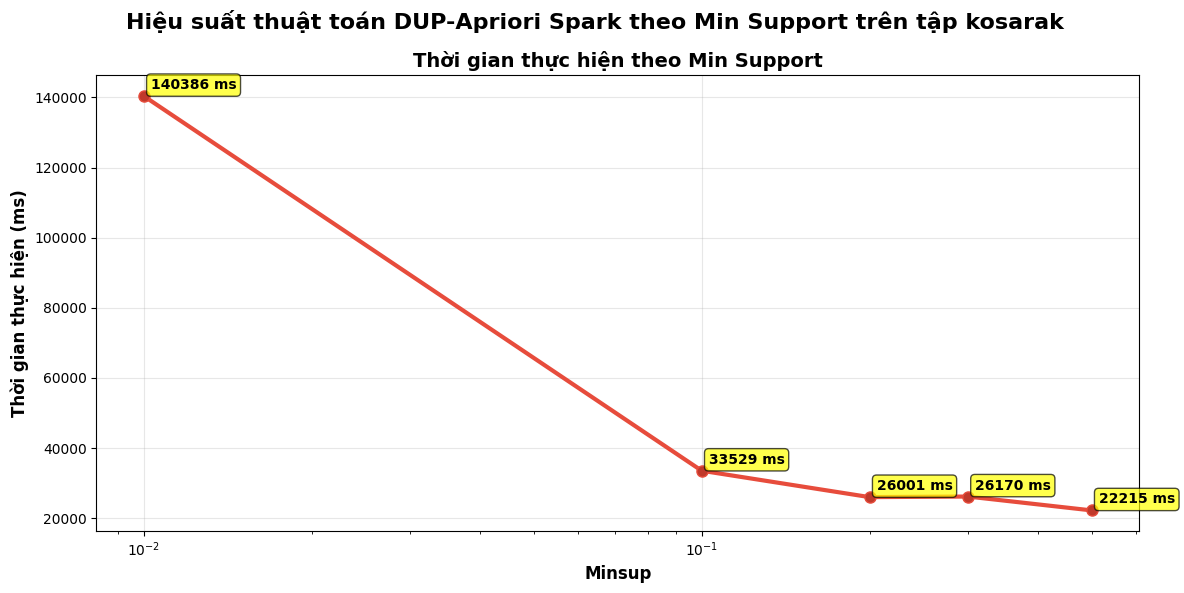


📋 BẢNG TÓM TẮT KẾT QUẢ HIỆU SUẤT TRÊN TẬP kosarak
Min Support  Thời gian (ms)  Itemsets     Tốc độ (itemsets/ms)  
----------------------------------------------------------------------
0.5          22215           1            0.00                  
0.3          26170           4            0.00                  
0.2          26001           5            0.00                  
0.1          33529           9            0.00                  
0.01         140386          262          0.00                  


In [76]:
def create_performance_visualization(minsup_values, exec_times, itemset_counts):
    """
    Tạo biểu đồ trực quan hóa hiệu suất theo minsup
    """
    if not minsup_values or not exec_times:
        print("❌ Không có dữ liệu để vẽ biểu đồ!")
        return
    
    # Chuyển đổi thời gian sang mili giây
    exec_times_ms = [t * 1000 for t in exec_times]
    
    # Tạo figure
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
    fig.suptitle(f'Hiệu suất thuật toán DUP-Apriori Spark theo Min Support trên tập {dataset_name}', 
                 fontsize=16, fontweight='bold')
    
    # Biểu đồ 1: Thời gian thực hiện theo minsup (mili giây)
    ax1.plot(minsup_values, exec_times_ms, 'ro-', linewidth=3, markersize=8, 
             color='#e74c3c', markerfacecolor='#c0392b')
    ax1.set_xlabel('Minsup', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Thời gian thực hiện (ms)', fontsize=12, fontweight='bold')
    ax1.set_title('Thời gian thực hiện theo Min Support', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xscale('log')  # Scale logarit cho minsup để dễ quan sát
    # Không dùng log scale cho trục y để số liệu đúng thực tế
    
    # Thêm annotations cho các điểm (hiển thị mili giây, không nhân x10)
    for minsup, exec_time_ms in zip(minsup_values, exec_times_ms):
        ax1.annotate(f'{exec_time_ms:.0f} ms', 
                    xy=(minsup, exec_time_ms), 
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    # In bảng tóm tắt kết quả
    print("\n" + "="*70)
    print(f"📋 BẢNG TÓM TẮT KẾT QUẢ HIỆU SUẤT TRÊN TẬP {dataset_name}")
    print("="*70)
    print(f"{'Min Support':<12} {'Thời gian (ms)':<15} {'Itemsets':<12} {'Tốc độ (itemsets/ms)':<22}")
    print("-" * 70)
    
    for minsup, exec_time_ms, count in zip(minsup_values, exec_times_ms, itemset_counts):
        speed = count / exec_time_ms if exec_time_ms > 0 else 0
        print(f"{minsup:<12} {exec_time_ms:<15.0f} {count:<12,} {speed:<22.2f}")

# Tạo visualization nếu có dữ liệu
if minsup_values and exec_times and itemset_counts:
    create_performance_visualization(minsup_values, exec_times, itemset_counts)
else:
    print("⚠️ Không có dữ liệu để tạo biểu đồ. Vui lòng chạy benchmark trước.")